N = 3072

--- Simulation for η = 0.1 ---
Step 0 (thermalizing)
Step 1000 (thermalizing)
Step 2000 (thermalizing)
Step 3000 (thermalizing)
Step 4000 (thermalizing)

Number fluctuation table:
Region ℓ     <N>          ΔN          
------------------------------------
16.00        768.00       192.41      
8.00         192.00       89.25       
4.00         48.00        30.42       
2.00         12.00        9.49        
------------------------------------
Estimated z for η=0.1 : 0.729


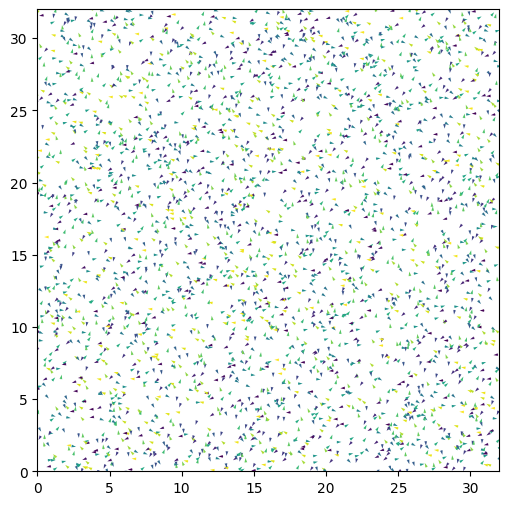

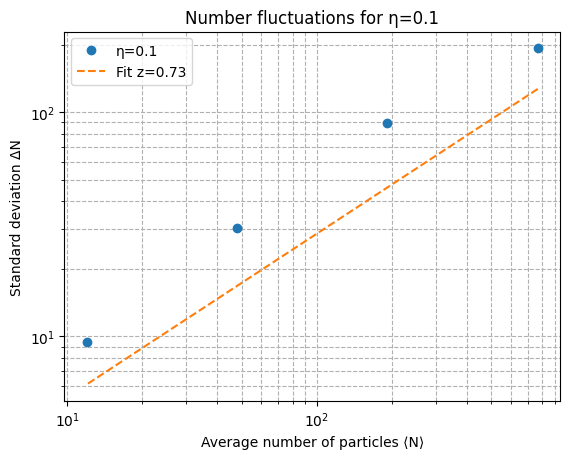


--- Simulation for η = 0.3 ---
Step 0 (thermalizing)
Step 1000 (thermalizing)
Step 2000 (thermalizing)
Step 3000 (thermalizing)
Step 4000 (thermalizing)

Number fluctuation table:
Region ℓ     <N>          ΔN          
------------------------------------
16.00        768.00       119.30      
8.00         192.00       59.68       
4.00         48.00        21.08       
2.00         12.00        7.10        
------------------------------------
Estimated z for η=0.3 : 0.686


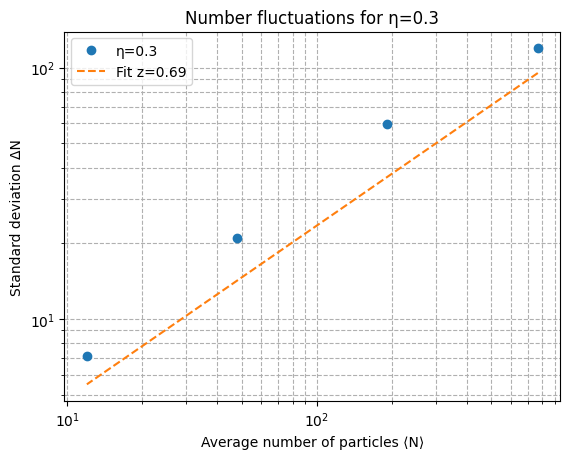


--- Simulation for η = 0.4 ---
Step 0 (thermalizing)
Step 1000 (thermalizing)
Step 2000 (thermalizing)
Step 3000 (thermalizing)
Step 4000 (thermalizing)

Number fluctuation table:
Region ℓ     <N>          ΔN          
------------------------------------
16.00        768.00       199.34      
8.00         192.00       81.72       
4.00         48.00        27.27       
2.00         12.00        8.31        
------------------------------------
Estimated z for η=0.4 : 0.767


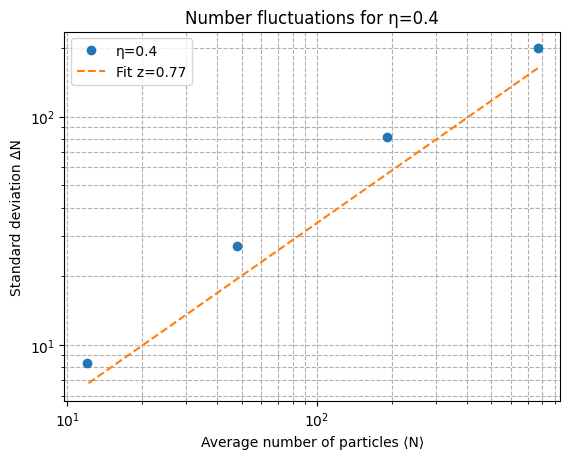


--- Simulation for η = 0.5 ---
Step 0 (thermalizing)
Step 1000 (thermalizing)
Step 2000 (thermalizing)
Step 3000 (thermalizing)
Step 4000 (thermalizing)

Number fluctuation table:
Region ℓ     <N>          ΔN          
------------------------------------
16.00        768.00       165.44      
8.00         192.00       81.57       
4.00         48.00        28.02       
2.00         12.00        8.81        
------------------------------------
Estimated z for η=0.5 : 0.712


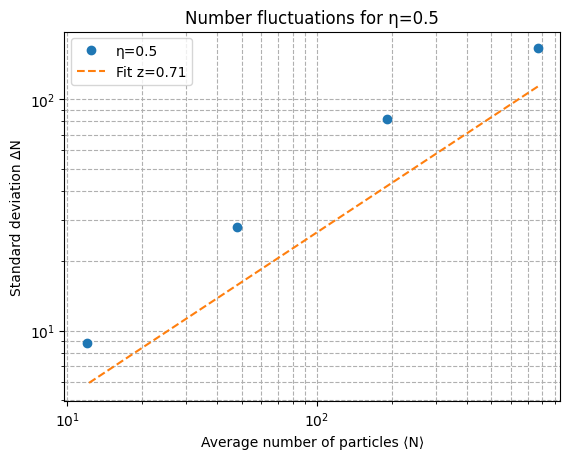


--- Simulation for η = 0.6 ---
Step 0 (thermalizing)
Step 1000 (thermalizing)
Step 2000 (thermalizing)
Step 3000 (thermalizing)
Step 4000 (thermalizing)

Number fluctuation table:
Region ℓ     <N>          ΔN          
------------------------------------
16.00        768.00       98.22       
8.00         192.00       48.13       
4.00         48.00        20.34       
2.00         12.00        7.13        
------------------------------------
Estimated z for η=0.6 : 0.630


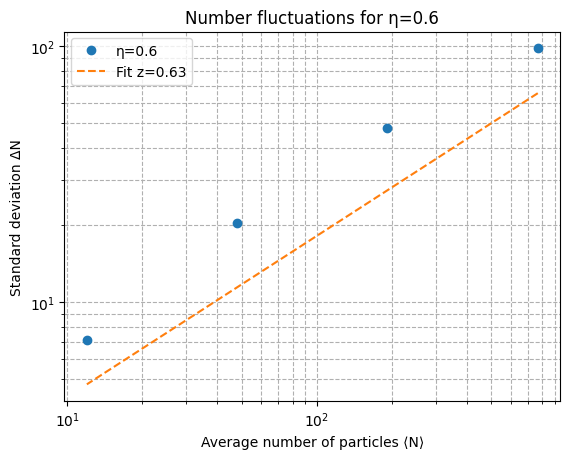


--- Simulation for η = 0.8 ---
Step 0 (thermalizing)
Step 1000 (thermalizing)
Step 2000 (thermalizing)
Step 3000 (thermalizing)
Step 4000 (thermalizing)

Number fluctuation table:
Region ℓ     <N>          ΔN          
------------------------------------
16.00        768.00       28.96       
8.00         192.00       15.09       
4.00         48.00        8.29        
2.00         12.00        3.92        
------------------------------------
Estimated z for η=0.8 : 0.476


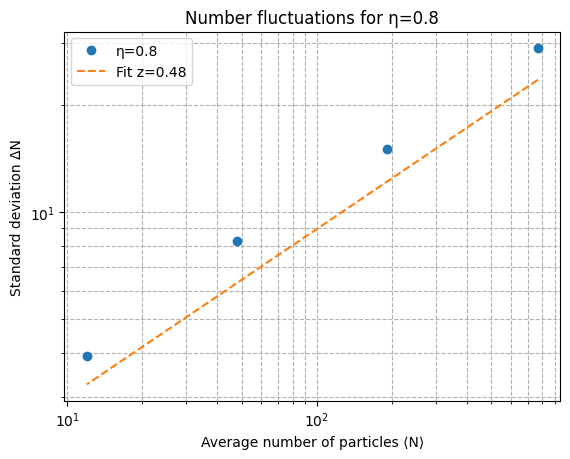


--- Simulation for η = 1.0 ---
Step 0 (thermalizing)
Step 1000 (thermalizing)
Step 2000 (thermalizing)
Step 3000 (thermalizing)
Step 4000 (thermalizing)

Number fluctuation table:
Region ℓ     <N>          ΔN          
------------------------------------
16.00        768.00       20.52       
8.00         192.00       13.40       
4.00         48.00        6.76        
2.00         12.00        3.40        
------------------------------------
Estimated z for η=1.0 : 0.438


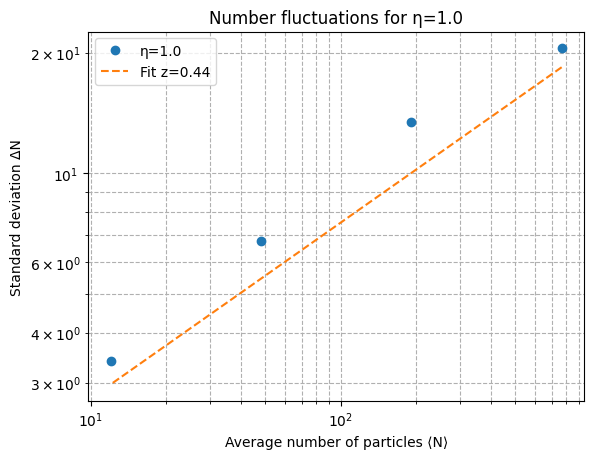


Summary of z-exponent vs noise η:
η = 0.10, z = 0.729
η = 0.30, z = 0.686
η = 0.40, z = 0.767
η = 0.50, z = 0.712
η = 0.60, z = 0.630
η = 0.80, z = 0.476
η = 1.00, z = 0.438


In [5]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib.animation as animation

L = 32.0
rho = 3.0
N = int(rho * L**2)
print("N =", N)

r0 = 1.0
deltat = 1.0
factor = 0.5
v0 = r0 / deltat * factor
n_therm = 5000
iterations = 1000
region_sizes = [L/2, L/4, L/8, L/16]
eta_values = [0.1, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]

pos = np.random.uniform(0, L, (N, 2))
orient = np.random.uniform(-np.pi, np.pi, N)

fig, ax = plt.subplots(figsize=(6,6))
qv = ax.quiver(pos[:,0], pos[:,1], np.cos(orient), np.sin(orient), orient, clim=[-np.pi, np.pi])
ax.set_xlim(0,L)
ax.set_ylim(0,L)
ax.set_aspect('equal')

def step(current_eta):
    global pos, orient

    tree = cKDTree(pos, boxsize=[L,L])
    dist = tree.sparse_distance_matrix(tree, max_distance=r0, output_type='coo_matrix')

    data = np.exp(1j*orient[dist.col])
    neigh = sparse.coo_matrix((data, (dist.row, dist.col)), shape=dist.get_shape())

    S = np.zeros(N, dtype=complex)
    S[:neigh.shape[0]] = np.asarray(neigh.tocsr().sum(axis=1)).flatten()

    orient[:] = np.angle(S) + current_eta * np.random.uniform(-np.pi, np.pi, size=N)

    cos, sin = np.cos(orient), np.sin(orient)
    pos[:,0] += cos * v0
    pos[:,1] += sin * v0

    pos[pos>L] -= L
    pos[pos<0] += L

def animate(i):
    step(current_eta=eta_global)
    qv.set_offsets(pos)
    qv.set_UVC(np.cos(orient), np.sin(orient), orient)
    return qv,

def measure_local_N(pos, region_sizes):
    N_local = {}
    for l in region_sizes:
        n_cells = int(L / l)
        counts = np.zeros((n_cells, n_cells), dtype=int)
        cell_x = (pos[:,0] // l).astype(int)
        cell_y = (pos[:,1] // l).astype(int)
        for x, y in zip(cell_x, cell_y):
            counts[x, y] += 1
        N_local[l] = counts.flatten()
    return N_local

z_results = []

for eta_global in eta_values:
    print(f"\n--- Simulation for η = {eta_global} ---")

    for t in range(n_therm):
        step(eta_global)
        if t % 1000 == 0:
            print(f"Step {t} (thermalizing)")

    num_samples = 10
    all_mean_N = []
    all_std_N = []

    for sample in range(num_samples):
        for _ in range(100):
            step(eta_global)

        N_local = measure_local_N(pos, region_sizes)
        mean_N_sample = [np.mean(N_local[l]) for l in region_sizes]
        std_N_sample = [np.std(N_local[l]) for l in region_sizes]

        all_mean_N.append(mean_N_sample)
        all_std_N.append(std_N_sample)

    mean_N = np.mean(all_mean_N, axis=0)
    std_N = np.mean(all_std_N, axis=0)

    print("\nNumber fluctuation table:")
    print("{:<12} {:<12} {:<12}".format("Region ℓ", "<N>", "ΔN"))
    print("-"*36)
    for l, mn, sd in zip(region_sizes, mean_N, std_N):
        print("{:<12.2f} {:<12.2f} {:<12.2f}".format(l, mn, sd))
    print("-"*36)

    mask = np.array(std_N) > 0
    z, log_C = np.polyfit(np.log(np.array(mean_N)[mask]), np.log(np.array(std_N)[mask]), 1)
    z_results.append(z)
    print(f"Estimated z for η={eta_global} : {z:.3f}")

    plt.figure()
    plt.loglog(mean_N, std_N, 'o', label=f'η={eta_global}')
    plt.loglog(mean_N, np.array(mean_N)**z, '--', label=f'Fit z={z:.2f}')
    plt.xlabel("Average number of particles ⟨N⟩")
    plt.ylabel("Standard deviation ΔN")
    plt.title(f"Number fluctuations for η={eta_global}")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

print("\nSummary of z-exponent vs noise η:")
for eta_val, z_val in zip(eta_values, z_results):
    print(f"η = {eta_val:.2f}, z = {z_val:.3f}")
